#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5946603360130090726
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2282631910786451049
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [16]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [17]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [18]:
As = data
Cd = data
Ni = data

In [19]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [20]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [21]:
import smogn

In [23]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

r_index: 100%|##########| 91/91 [00:00<00:00, 554.75it/s]


In [24]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [25]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [26]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [27]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [28]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [29]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(859, 15)
(1216, 15)
(1090, 15)


StandardScaler

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [31]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(687, 15)
(972, 15)
(872, 15)


#### 10-Fold Crossvalidation

In [32]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [33]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [34]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [35]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 01:36:05,171] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 01:36:05,534] Trial 0 finished with value: 0.19791536121419853 and parameters: {'n_estimators': 57, 'max_depth': 1, 'min_samples_leaf': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.19791536121419853.
[I 2023-08-15 01:36:05,671] Trial 1 finished with value: 0.18368370076276816 and parameters: {'n_estimators': 21, 'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 19}. Best is trial 0 with value: 0.19791536121419853.
[I 2023-08-15 01:36:06,135] Trial 2 finished with value: 0.4183956751912187 and parameters: {'n_estimators': 58, 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 4}. Best is trial 2 with value: 0.4183956751912187.
[I 2023-08-15 01:36:06,627] Trial 3 finished with value: 0.1977226700665915 and parameters: {'n_estimators': 77, 'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 15}. Best is trial 2 with value: 0.4183956751912187.
[I 202

Best r2:  0.5295385146295486
Best trial: {'n_estimators': 70, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [36]:
optuna.visualization.plot_parallel_coordinate(study)

In [37]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 70, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [38]:
study.best_trial.params["n_estimators"]

70

In [39]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=70,
                      random_state=42)

In [40]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [41]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [42]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.1601692889078824
Test RMSE:  0.34759508544052564


In [43]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8933604285393968
Test R2:  0.5205229298101162


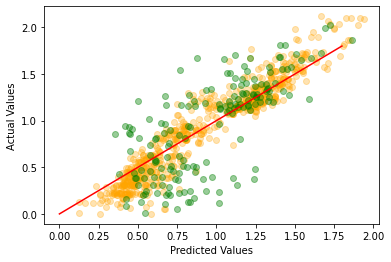

In [44]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [45]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 01:50:11,780] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 01:50:12,274] Trial 0 finished with value: 0.4595326567604003 and parameters: {'n_estimators': 41, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.4595326567604003.
[I 2023-08-15 01:50:13,019] Trial 1 finished with value: 0.4869380035195373 and parameters: {'n_estimators': 58, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 1 with value: 0.4869380035195373.
[I 2023-08-15 01:50:13,698] Trial 2 finished with value: 0.38801615945396095 and parameters: {'n_estimators': 79, 'max_depth': 3, 'min_samples_leaf': 11, 'min_samples_split': 19}. Best is trial 1 with value: 0.4869380035195373.
[I 2023-08-15 01:50:13,992] Trial 3 finished with value: 0.4318410598534195 and parameters: {'n_estimators': 27, 'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 9}. Best is trial 1 with value: 0.4869380035195373.
[I 2023-

Best r2:  0.5400957441552908
Best trial: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [46]:
optuna.visualization.plot_parallel_coordinate(study)

In [47]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


100

In [48]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [49]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [50]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.032376913355273235
Test RMSE:  0.05279408022418442


In [51]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8543541665156794
Test R2:  0.576235118277312


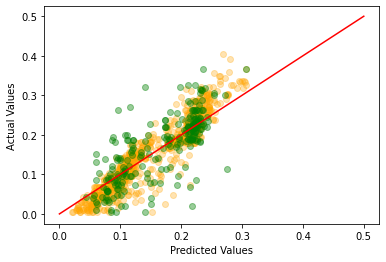

In [52]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [53]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 02:13:33,573] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 02:13:33,795] Trial 0 finished with value: 0.2441094901106231 and parameters: {'n_estimators': 34, 'max_depth': 1, 'min_samples_leaf': 11, 'min_samples_split': 2}. Best is trial 0 with value: 0.2441094901106231.
[I 2023-08-15 02:13:34,263] Trial 1 finished with value: 0.7575853977234036 and parameters: {'n_estimators': 35, 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 15}. Best is trial 1 with value: 0.7575853977234036.
[I 2023-08-15 02:13:34,528] Trial 2 finished with value: 0.5309393951738638 and parameters: {'n_estimators': 37, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 7}. Best is trial 1 with value: 0.7575853977234036.
[I 2023-08-15 02:13:35,041] Trial 3 finished with value: 0.5272540240302133 and parameters: {'n_estimators': 74, 'max_depth': 2, 'min_samples_leaf': 11, 'min_samples_split': 7}. Best is trial 1 with value: 0.7575853977234036.
[I 2023-08-

Best r2:  0.807528594402435
Best trial: {'n_estimators': 45, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [54]:
optuna.visualization.plot_parallel_coordinate(study)

In [55]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 45, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}


45

In [56]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=9, n_estimators=45, random_state=42)

In [57]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [58]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.2991618444915054
Test RMSE:  0.5041812950761201


In [59]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9375901666921067
Test R2:  0.8260746222483867


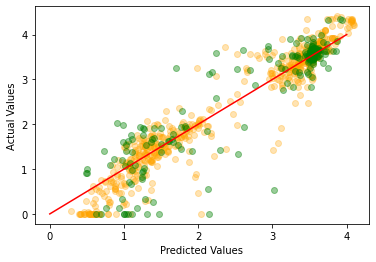

In [60]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()